In [1]:
# _______initializiere Tensorflow_________
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.0-rc1


In [0]:
# __________Download Daten_________
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

In [0]:
# ________Importieren____________ 
# Spaltenüberschriften
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
# Variable Datenset deklarieren
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
# Daten 397-x
dataset.tail()

In [0]:
# __________Daten anpassen_________
dataset.isna().sum()

In [0]:
dataset = dataset.dropna()

In [0]:
# Spalten hinzufügen
# Spalte Origin enthält Zahlen für das Ort--> Neue Spalte für Ort
origin = dataset.pop('Origin')


In [0]:
# 1:USA, 2:Europa, 3:Japan
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

In [0]:
# _________Daten aufteilen_______
# Trainingsdaten
train_dataset = dataset.sample(frac=0.8,random_state=0)
# Testdaten
test_dataset = dataset.drop(train_dataset.index)

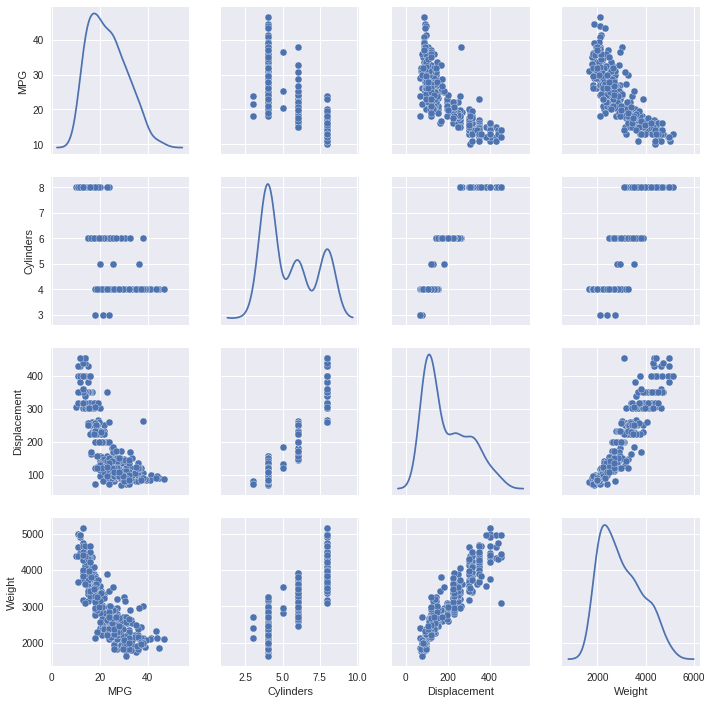

In [23]:
# ________Daten analysieren________
# Daten plotten
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [24]:
# Überblick Trainingsdaten
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [0]:
# ________Wonach Trainieren? --> MPG______
# Trainingsdaten seperieren
train_labels = train_dataset.pop('MPG')
# Testdaten seperieren
test_labels = test_dataset.pop('MPG')

In [0]:
# _________Daten Normalisieren_________
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
# __________Netz mit 2 Layer und 1 Outputlayer________
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

# Optimizer: 0.001:Lernrate optimizer adam auch möglich
  optimizer = tf.keras.optimizers.RMSprop(0.001)

# Regression: Fehlerfunktion 'mse'
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [28]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [29]:
# ______Beschreibung des Netzes_______
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [30]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.03268887],
       [-0.0877744 ],
       [-0.5753709 ],
       [ 0.02531292],
       [ 0.15950531],
       [-0.2148963 ],
       [ 0.16077562],
       [-0.37144375],
       [-0.26869503],
       [ 0.43774727]], dtype=float32)

In [31]:
#__________Netz Trainieren________
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [32]:
# ____________Netz visualisieren___________
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.795090,1.073207,2.795090,9.822780,2.431980,9.822780,995
996,2.816128,1.046342,2.816128,9.795586,2.367705,9.795587,996
997,2.883516,1.082626,2.883516,9.658680,2.376850,9.658680,997
998,2.749051,1.036588,2.749051,9.854966,2.442615,9.854966,998
999,2.688920,1.053729,2.688919,9.730524,2.424511,9.730524,999


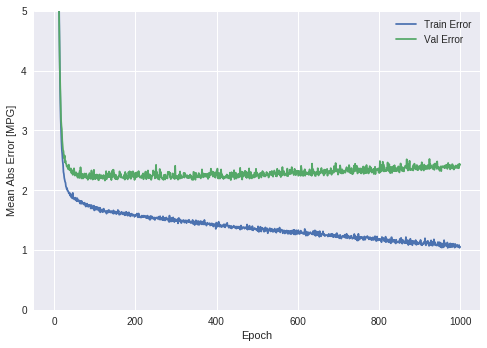

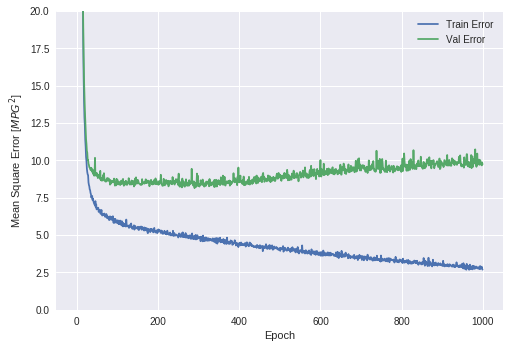

In [33]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


...............................................

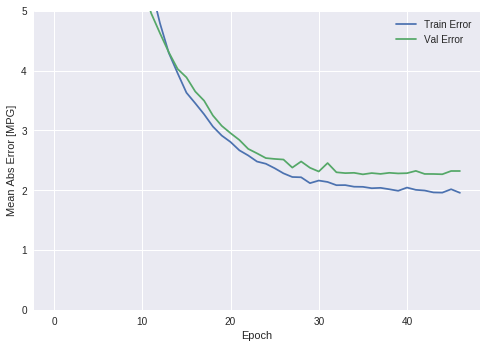

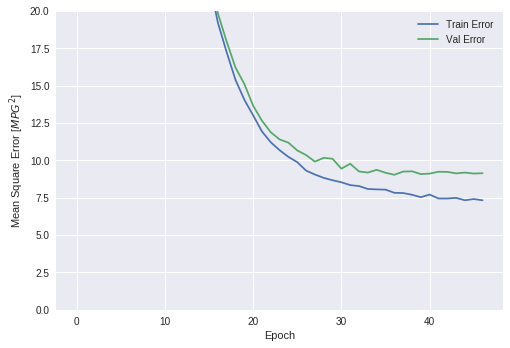

In [34]:
# ________Stopp Funktion___________
# da nach ca. 100 Iterationen keine Verbesserung--> StoppFunktion

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

# --> durchschnittlicher Fehler  der Validierungsdaten +/-2 MPG

In [35]:
# __________Fehler beim TEST-set____________
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.96 MPG


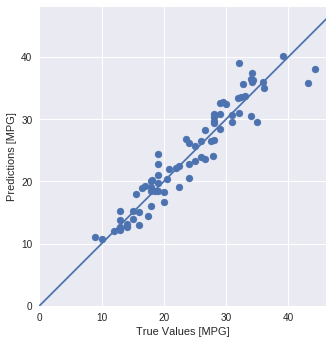

In [36]:
# _________Vergleich Prädizierter Wert/Echter Wert_____
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

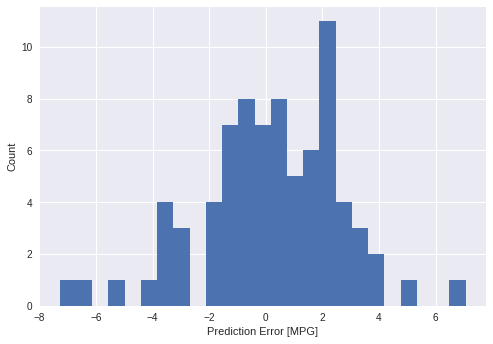

In [37]:
# ________Fehlerkollektiv__________
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# --> leicht Gaußverteilt (geringe Datenmenge)